# Introduction to PyCBA

PyCBA (Python Continuous Beam Analysis) is a general linear elastic one-dimensional beam analysis package.

This introduction demonstrates the basic use of `PyCBA` and results that can be obtained. So let's get started...

In [1]:
# Basic imports
import pycba as cba  # The main package
import numpy as np  # For arrays
import matplotlib.pyplot as plt  # For plotting
from IPython import display  # For images in this notebook

## Example 1 - Basic Analysis
Analyse a two span beam, with a UDL of 20 kN/m on each span

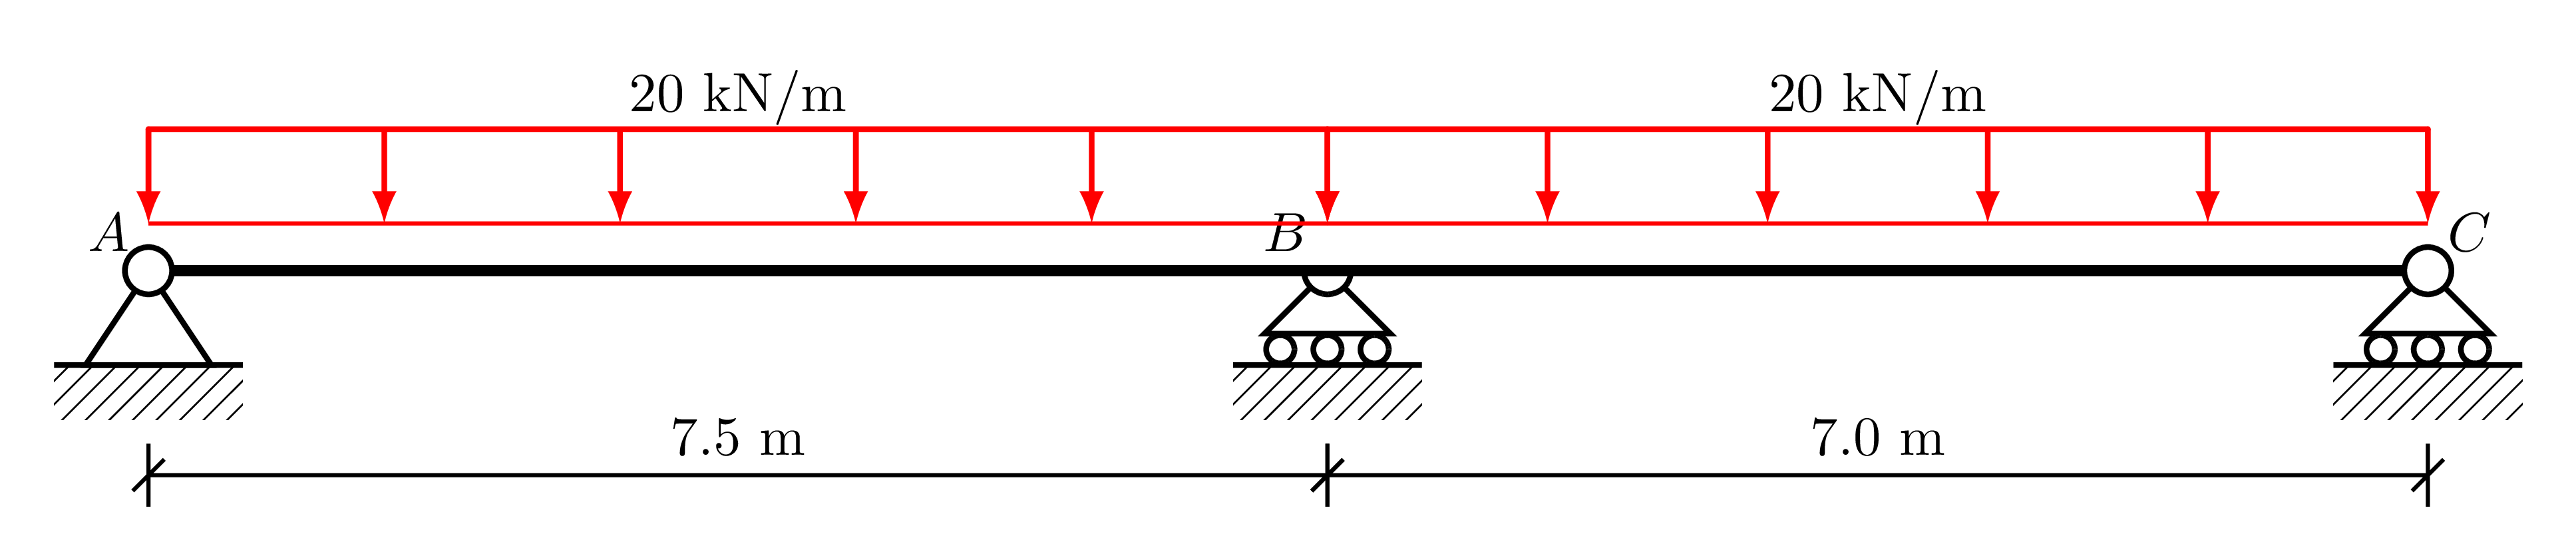

In [2]:
display.Image("./images/intro_ex_1.png",width=800)

Here is the specification for `PyCBA`, explained below:

In [3]:
L = [7.5, 7.0]
EI = 30 * 600e7 * 1e-6
R = [-1, 0, -1, 0, -1, 0]
LM = [[1, 1, 20, 0, 0], [2, 1, 20, 0, 0]]

Initially, we define the member lengths, which in this case coincides with the spans, $AB$, and $BC$. 

The flexural rigidity (elastic modulus multiplied by the second moment of area) can be defined for each member, or if a scalar value is passed, this is assigned to all members. Here we take $E = 30$ GPa and $I = 600 \times 10^7$ mm$^4$, and apply a conversion to put it into a consistent set of units (kN and m).

The beam restraints at each nodal degree of freedom are then defined. Since there are three nodes, this will be a vector of $2 \times 3 = 6$ entries. Only the vertical (and not rotational) degree of freedom is restrained at nodes $A$, $B$, and $C$, and so this is indicated using $-1$ and $0$ for unrestrained.

Finally, the load matrix is defined, which is a list of loads, where each load is defined by a list of five numbers, as defined in the docs:
```
Span No. | Load Type | Load Value | Distance a | Load Cover c
```
For UDLs covering the full length of the member, only the span number, load type, and value have non-zero entries.

With the basic variables defined, we construct the `beam_analysis` object by passing these variables, we then call the `analyze()` function and plot the results:

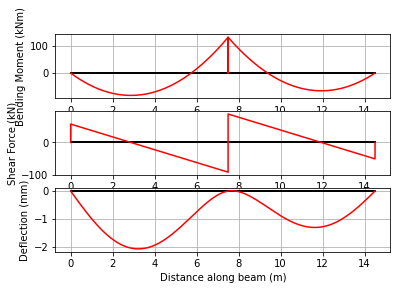

In [4]:
beam_analysis = cba.BeamAnalysis(L, EI, R, LM)
beam_analysis.analyze()
beam_analysis.plot_results()

The numerical results can found from the `beam_results` member of `beam_analysis` object.

For example, the reactions corresponding to the fully-restrained nodes are:

In [5]:
beam_analysis.beam_results.R

array([ 57.41666667, 181.42261905,  51.16071429])

and the maximum bending moment along the second member, $BC$, can be got from:

In [6]:
beam_analysis.beam_results.vRes[1].M.max()

65.42525

Since we have been consistent with our units, the reactions are in kN and the bending moment in kNm.

## Example 2 - Load Definitions

In this example, we consider a two-span beam with a fixed remote end, and more load types.

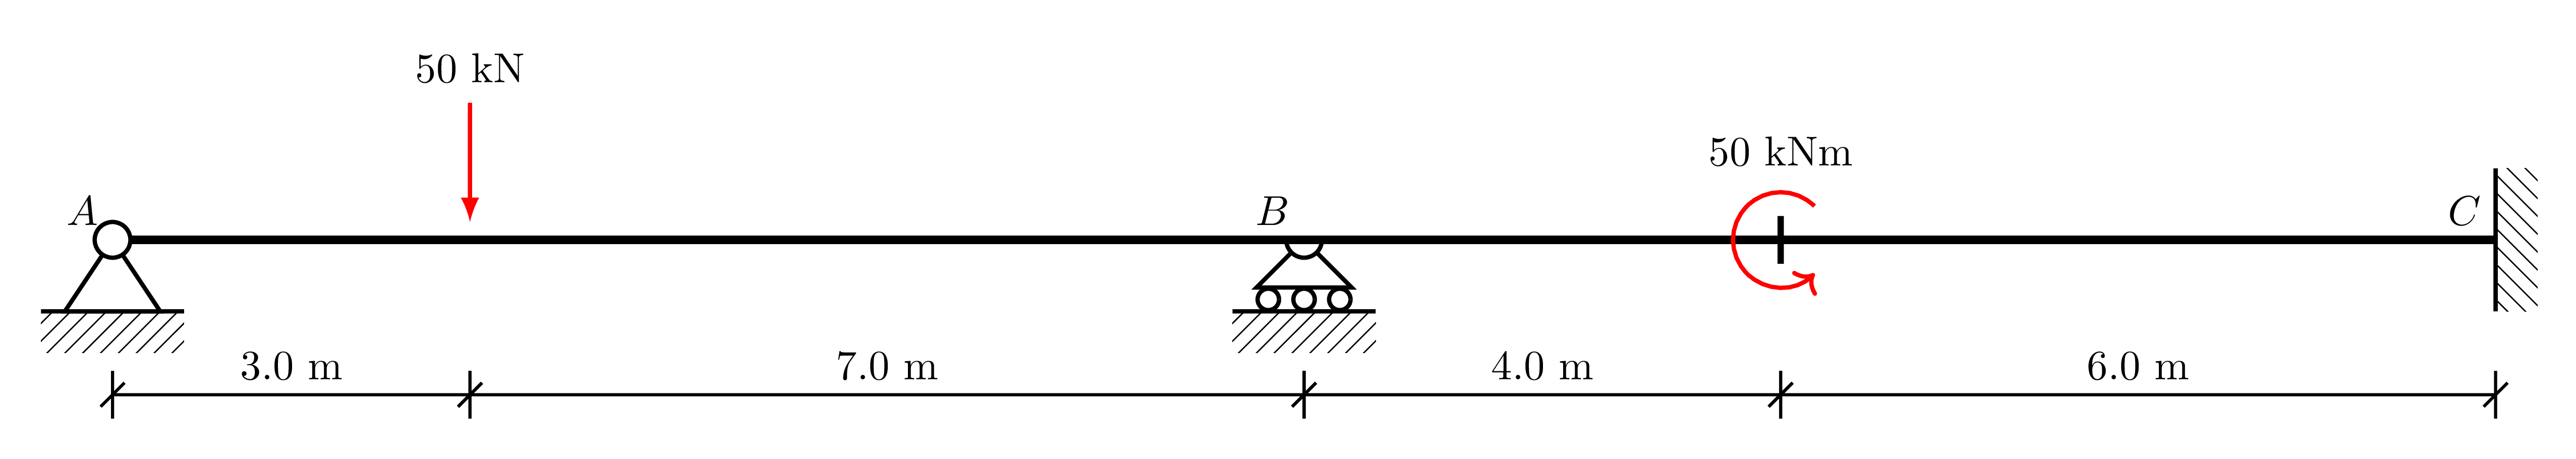

In [7]:
display.Image("./images/intro_ex_2.png",width=800)

With two loads the *load matrix* (see `pycba.load`) is a list of two lists:

- Span 1: point load is load type 2, with a value of $50$ kN, at $a = 3$ m
- Span 2: moment load is load type 4, anti-clockwise positive $50$ kNm, at $a = 4$ m

Note, also that node $C$ will have its two degrees of freedom restrained.

In [8]:
L = [10.0, 10.0]
EI = 30 * 600e7 * 1e-6  # kNm2
R = [-1, 0, -1, 0, -1, -1]
LM = [[1, 2, 50, 3, 0], [2, 4, 50, 4, 0]]

And to better evaluate the discontinuities for the moment and point loads, we can increase the number of evaluation points along each member to 500 when calling `analyze()` as follows:

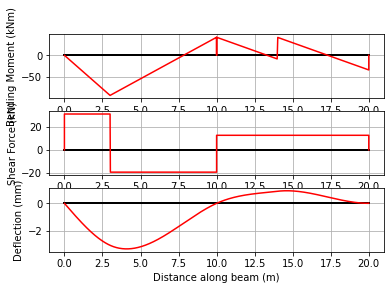

In [9]:
beam_analysis = cba.BeamAnalysis(L, EI, R, LM)
beam_analysis.analyze(500)
beam_analysis.plot_results()